# Análisis de series temporales: progreso de la vacunación de la Covid-19



## Índice

0. Introducción

 - Funciones 
 - Base de datos
 - Preprocesado y comprobación de missing values (NaN)

Para un país:España.

1. Series temporales: AR, ARMA, ARIMA
2. Series temporales: VAR
3. Ajustes de curva de vacunación: lineal, potencia, cuadrática, exponencial y logística

Para Un continente: Europa.

4. Ajustes de curva de vacunación: lineal, potencia, cuadrática, exponencial y logística

In [1]:
import warnings 
warnings.filterwarnings("ignore")

import pandas as pd
from pandas import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.api import tsa

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


### Funciones

In [2]:
def preprocesado_pais(covid_vaccine_data,pais):
    """
    covid_vaccine_data: dataframe con todas las vacunas
    pais: pais que queremos escoger para analizar
    """
    vacc_pais = covid_vaccine_data.loc[covid_vaccine_data.country == pais]
    #print(pais)
    vacc_pais.set_index('date',inplace=True)
    
    
    #crear una funcion de preprocesado
    vacc_pais['daily_vaccinations']= vacc_pais['daily_vaccinations'].interpolate(method='cubicspline')
    vacc_pais['total_vaccinations']= vacc_pais['total_vaccinations'].interpolate(method='cubicspline')
    vacc_pais['people_vaccinated']= vacc_pais['people_vaccinated'].interpolate(method='cubicspline')

    vacc_pais['people_fully_vaccinated']= vacc_pais['people_fully_vaccinated'].interpolate(method='cubicspline')
    vacc_pais['total_vaccinations_per_hundred']= vacc_pais['total_vaccinations_per_hundred'].interpolate(method='cubicspline')
    vacc_pais['people_vaccinated_per_hundred']= vacc_pais['people_vaccinated_per_hundred'].interpolate(method='cubicspline')

    vacc_pais['people_fully_vaccinated_per_hundred']=vacc_pais['people_fully_vaccinated_per_hundred'].interpolate(method='cubicspline')
    vacc_pais['daily_vaccinations_per_million']= vacc_pais['daily_vaccinations_per_million'].interpolate(method='cubicspline')

    vacc_pais = vacc_pais.fillna(vacc_pais.median())
    
    vacc_pais["date"] = vacc_pais.index
    vacc_pais["Days"]=vacc_pais.date - vacc_pais.date.min()
    vacc_pais["Days"]=vacc_pais["Days"].dt.days
    
    population = vacc_pais["Population"][1]
    vacc_pais['percentage_vaccinated'] = (vacc_pais.people_fully_vaccinated/population)*100
    
    return vacc_pais

### Base de datos

Cargamos la base de datos que obtenemos del otro cuaderno jupyter: 'covid_vaccine_data.csv'

In [3]:
covid_vaccine_data = pd.read_csv('covid_vaccine_data.csv')

covid_vaccine_data['date'] = pd.to_datetime(covid_vaccine_data['date'])
covid_vaccine_data['date'] = covid_vaccine_data['date'].dt.strftime('%Y-%m-%d')
covid_vaccine_data[['date']] = covid_vaccine_data[['date']].apply(pd.to_datetime)

#PARSEAMOS Y NOS QUEDAMOS CON LOS DATOS DE ESPAÑA
vacc_Spain = preprocesado_pais(covid_vaccine_data,'Spain')
vacc_Spain.shape

(122, 20)

In [4]:
print('El rango que nuestros datos abarcan es de',len(covid_vaccine_data.date.unique()),'días de vacunación')

El rango que nuestros datos abarcan es de 144 días de vacunación


### Comprobación de missing values.

Nos aseguramos de que no tenemos ningún NaN para que no haya problemas al construir nuestros modelos:

In [5]:
vacc_Spain.isnull().sum()

Unnamed: 0                             0
iso_code                               0
country                                0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
daily_vaccinations                     0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
daily_vaccinations_per_million         0
vaccines                               0
source_name                            0
source_website                         0
Population                             0
Full_vaccinations(count)               0
Total_vaccinations(count)              0
date                                   0
Days                                   0
percentage_vaccinated                  0
dtype: int64

Está todo en orden, no hay NaN.

# Estimación en un país: España

## 1. Series temporales univariable: AR, ARMA, ARIMA

En esta sección nos vamos a centrar en los métodos **AR** (modelo autorregresivo), **ARMA** (autorregresivo de media móvil) y **ARIMA** (modelo autorregresivo integrado de media móvil). 

Son modelos estadístico que utiliza variaciones y regresiones de datos estadísticos para encontrar patrones para una predicción en el futuro. Se trata de un modelos dinámico de series temporales, es decir, las **estimaciones futuras se explican por los datos pasados**.

A continuación vamos a crear tres modelos con la finalidad de comprobar cuál es el más adecuado para predecir los datos de 'vacunaciones totales' y de 'gente totalmente vacunada' futuros en un horizonte de 7 días. 

Para ello nos centraremos en las variables:
 - *'people_fuly_vaccinated'*
 - *'total_vaccinations'* 
 
 del dataframe **vacc_Spain**.

In [6]:
#vacc_Spain.total_vaccinations

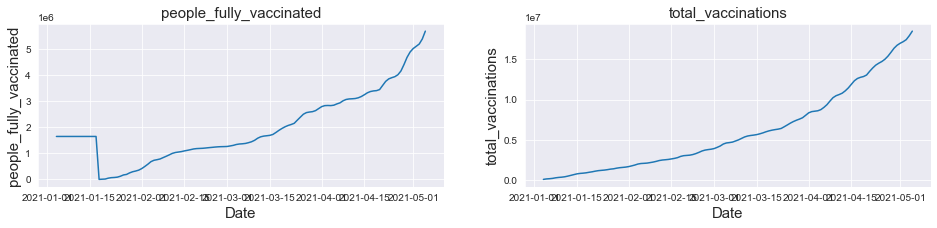

In [7]:
sns.set_style("darkgrid")
plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.title('people_fully_vaccinated')
sns.lineplot(data=vacc_Spain['people_fully_vaccinated'])
#sns.lineplot(data = vacc_Spain['daily_vaccinations'])
plt.title('people_fully_vaccinated',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.ylabel('people_fully_vaccinated', fontsize=15)

plt.subplot(122)
plt.title('total_vaccinations')
sns.lineplot(data=vacc_Spain['total_vaccinations'])
#sns.lineplot(data = vacc_Spain['daily_vaccinations'])
plt.title('total_vaccinations',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.ylabel('total_vaccinations', fontsize=15)
plt.show()


### Media semanal y mensual

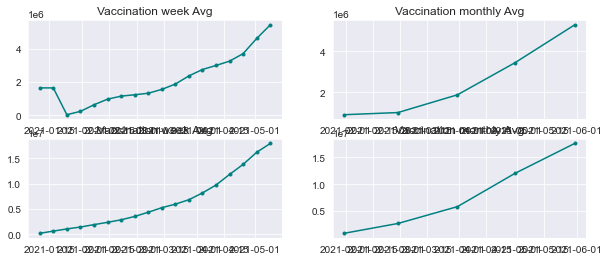

In [8]:
vacc_weekly_avg = vacc_Spain.resample('W').apply(np.mean)
vacc_monthly_avg = vacc_Spain.resample('M').apply(np.mean)

plt.figure(figsize=(10,4))
plt.subplot(221)
plt.title('Vaccination week Avg', loc='center')

plt.plot(vacc_weekly_avg.people_fully_vaccinated, "-o", markersize=3, color='teal')
plt.subplot(222)
plt.title('Vaccination monthly Avg', loc='center')
plt.plot(vacc_monthly_avg.people_fully_vaccinated, "-o", markersize=3, color='teal')

plt.subplot(223)
plt.title('Vaccination week Avg', loc='center')
plt.plot(vacc_weekly_avg.total_vaccinations, "-o", markersize=3, color='teal')
plt.subplot(224)
plt.title('Vaccination monthly Avg', loc='center')
plt.plot(vacc_monthly_avg.total_vaccinations, "-o", markersize=3, color='teal')
plt.show()

Otra forma de capturar la tendencia es a través de la media móvil que haremos a continuación. Básicamente tomamos una ventana de puntos de datos consecutivos, en nuestro caso se trata de una frecuencia diaria, calculamos la media de los mismos, y sustituimos toda la ventana por esa media, ya sea en el extremo derecho o en el centro de la ventana. Así que la ventana de 7 es lo mismo que la media semanal:

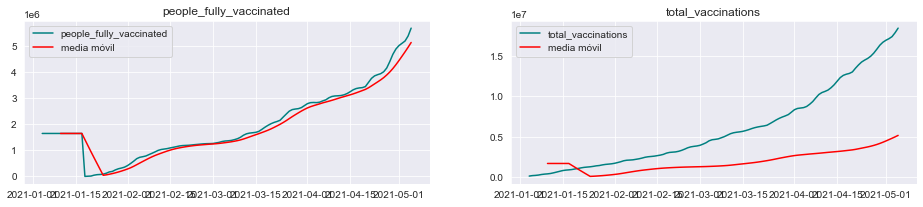

In [9]:
rolling_mean_people = vacc_Spain.people_fully_vaccinated.rolling(window=7, center=False).mean() #window of 7 (weekly avg) captures our data better 
rolling_mean_total = vacc_Spain.people_fully_vaccinated.rolling(window=7, center=False).mean() #window of 7 (weekly avg) captures our data better 


plt.figure(figsize=(16,3))
plt.subplot(121)
plt.plot(vacc_Spain.people_fully_vaccinated, color='teal', label = 'people_fully_vaccinated')
plt.plot(rolling_mean_people, 'red',label = 'media móvil')
plt.title('people_fully_vaccinated')
plt.legend()

plt.subplot(122)
plt.plot(vacc_Spain.total_vaccinations, color='teal', label = 'total_vaccinations')
plt.plot(rolling_mean_total, 'red',label = 'media móvil')
plt.title('total_vaccinations')
plt.legend()

### Datos  estacionarios y la autocorrelación¶

Tras algunas exploraciones iniciales, ha llegado el momento de crear nuestro modelo. Para ello, primero tenemos que hacer que la serie sea estacionaria, ya que es un requisito previo para la mayoría de los modelos. Hacer que los datos sean estacionarios significa quitarles la tendencia (quitarles la tendencia a los datos) para que sus propiedades estadísticas (es decir, la media y la varianza) sean constantes a lo largo del tiempo. Esto ayudará a que la muestra sea más predecible para el modelo, ya que se puede suponer que las propiedades estadísticas de los datos serán las mismas en el futuro que en el pasado. Una forma de estacionar una serie temporal es mediante la diferenciación, es decir, tomando la diferencia de dos puntos de datos dentro de un periodo determinado, este periodo se denomina **retardo** (lag) .

Para encontrar el **lag** óptimo utilizamos el método de autocorrelación.


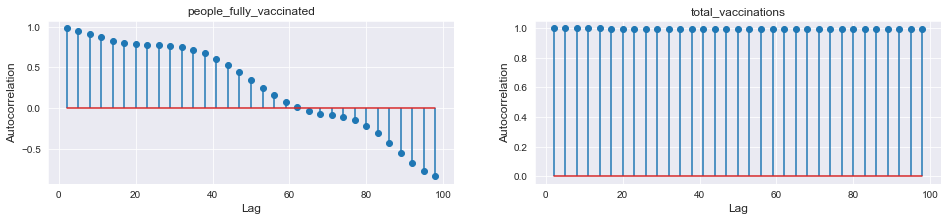

In [10]:
#lags = [7, 8, 10, 14, 17, 28, 30, 60, 90, 180]
lags = np.arange(2,100,3)
autocorrs_fully_vaccinated = [vacc_Spain.people_fully_vaccinated.autocorr(lag=lag) 
                   for lag in lags]


plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.stem(lags, autocorrs_fully_vaccinated)
plt.title('people_fully_vaccinated')
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)

autocorrs_total = [vacc_Spain.total_vaccinations.autocorr(lag=lag) 
                   for lag in lags]
plt.subplot(122)
plt.stem(lags, autocorrs_total)
plt.title('total_vaccinations')
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)

plt.show()

Según el gráfico anterior, la mayor correlación se produce con un desfase de 2, lo que significa que los datos repiten un patrón semanalmente.

Text(0.5, 1.0, 'people_fully_vaccinated')

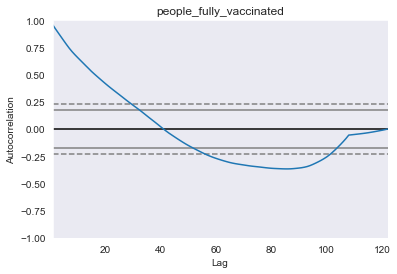

In [11]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(vacc_Spain['people_fully_vaccinated'])
plt.title('people_fully_vaccinated')

Text(0.5, 1.0, 'total_vaccinations')

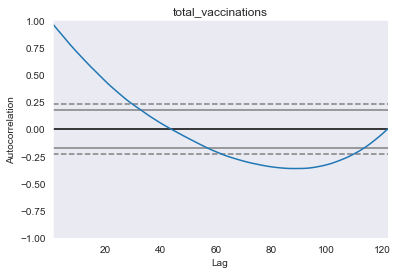

In [12]:
autocorrelation_plot(vacc_Spain['total_vaccinations'])
plt.title('total_vaccinations')

Podemos concluir que un desfase(lag) de 2 es un buen candidato para el desfase óptimo. Vamos a trazar la serie original frente a la versión retardada de la misma con una diferencia de 2. Esto significa que cada punto de datos (a partir del 2º) se deducirá de los datos de 7 días anteriores y se trazará en el gráfico (línea naranja inferior).

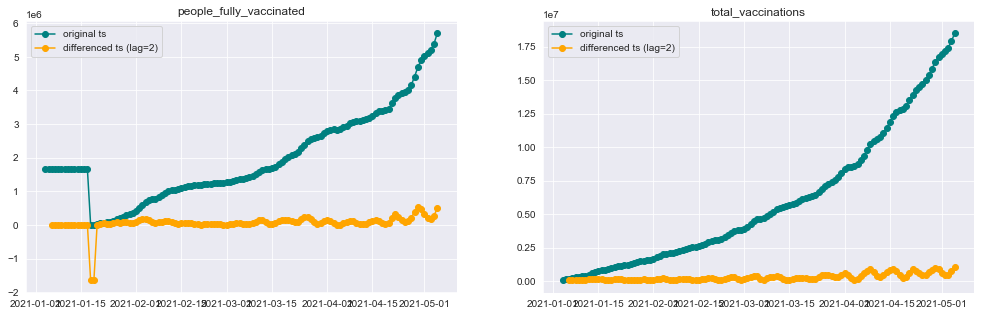

In [13]:
#people_fully_vaccinated
plt.figure(figsize=(17, 5))
plt.subplot(121)
plt.plot(vacc_Spain.people_fully_vaccinated, '-o', color='teal', label="original ts")
plt.plot(vacc_Spain.people_fully_vaccinated.diff(2), '-o', color='orange', label="differenced ts (lag=2)")
plt.title('people_fully_vaccinated')
plt.legend(fontsize=10)
plt.subplot(122)
plt.plot(vacc_Spain.total_vaccinations, '-o', color='teal', label="original ts")
plt.plot(vacc_Spain.total_vaccinations.diff(2), '-o', color='orange', label="differenced ts (lag=2)")
plt.title('total_vaccinations')
plt.legend(fontsize=10)

## Developing the models


Text(0.5, 1.0, 'total_vaccinations')

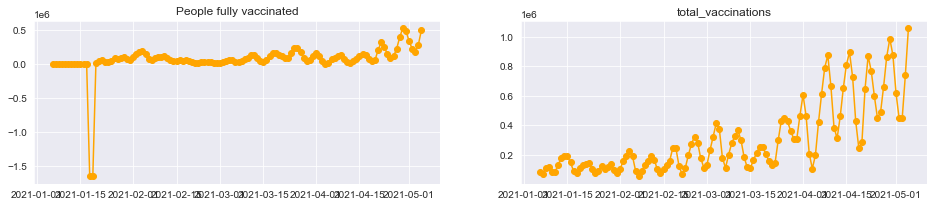

In [14]:
people_fully_vaccinated = vacc_Spain.people_fully_vaccinated
people_fully_vaccinated_diff =people_fully_vaccinated.diff(2)

total_vaccinations = vacc_Spain.total_vaccinations
total_vaccinations_diff =total_vaccinations.diff(2)

plt.figure(figsize=(16,3))
plt.subplot(121)
plt.plot(people_fully_vaccinated_diff, "-o", color='orange')
plt.title('People fully vaccinated')
plt.subplot(122)
plt.plot(total_vaccinations_diff, "-o", color='orange')
plt.title('total_vaccinations')

La figura anterior parece lo suficientemente estacionaria, por lo que se elige optlag=2 para las siguientes operaciones

Para empezar, guardemos los **datos estacionarios** en una nueva variable y llamémosla time_series:

In [15]:
time_series_people = people_fully_vaccinated_diff
time_series_total = total_vaccinations_diff


##  linearRegression and then AR and ARMA models (univariables) (time_series has not changed still diff=2)


Para la regresión lineal sobre series temporales necesitamos organizar los datos con la matriz X donde cada fila contiene un viento de previsión e y son los valores objetivo para cada fila de X.

In [16]:
time_series_people, time_series_total

(date
 2021-01-04              NaN
 2021-01-05              NaN
 2021-01-06         0.000000
 2021-01-07         0.000000
 2021-01-08         0.000000
                   ...      
 2021-05-01    336887.127638
 2021-05-02    219394.145980
 2021-05-03    175643.872362
 2021-05-04    280717.000000
 2021-05-05    494530.000000
 Name: people_fully_vaccinated, Length: 122, dtype: float64,
 date
 2021-01-04             NaN
 2021-01-05             NaN
 2021-01-06    8.426045e+04
 2021-01-07    6.798400e+04
 2021-01-08    1.108815e+05
                   ...     
 2021-05-01    6.174656e+05
 2021-05-02    4.452437e+05
 2021-05-03    4.487494e+05
 2021-05-04    7.380000e+05
 2021-05-05    1.058770e+06
 Name: total_vaccinations, Length: 122, dtype: float64)

In [17]:
#time_series
time_series_people = time_series_people.fillna(time_series_people.median())
time_series_total = time_series_total.fillna(time_series_total.median())

In [18]:
def organize_data(to_forecast, window, horizon=1):
    
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast,
                                        shape=shape,
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

lag = 2
X_people, y_people = organize_data(np.array(time_series_people), lag)
X_total, y_total = organize_data(np.array(time_series_total), lag)

#### Regresión lineal

people_fully_vaccinated: 
MAE = 64323.230
MAE2 = 39729.561
 
 
total_vaccinations: 
MAE = 62794.524
MAE2 = 72079.500


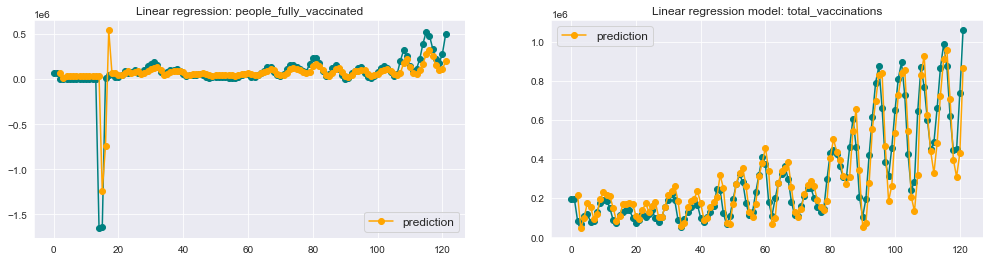

In [19]:
# 2 modelos: uno para people_fully_vaccinated y el otro para total_vaccinations
#people
lr = LinearRegression()
lr_fit_people = lr.fit(X_people, y_people)
lr_prediction_people = lr_fit_people.predict(X_people)
#total_vaccinations
lr_fit_total = lr.fit(X_total, y_total)
lr_prediction_total = lr_fit_total.predict(X_total)

plt.figure(figsize=(17, 4))
plt.subplot(121)
plt.plot(time_series_people.values, '-o', color='teal')
plt.plot(np.arange(lag, len(time_series_people)), lr_prediction_people, '-o', label='prediction', color='orange')
plt.title('Linear regression: people_fully_vaccinated')
plt.legend(fontsize=12);

print('people_fully_vaccinated: ')
print('MAE = {0:.3f}'.format(mean_absolute_error(time_series_people[lag:], lr_prediction_people)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series_people[-90:], lr_prediction_people[-90:]))) #for the last 90 days only

print(' \n ')
plt.subplot(122)
plt.plot(time_series_total.values, '-o', color='teal')
plt.plot(np.arange(lag, len(time_series_total)), lr_prediction_total, '-o', label='prediction', color='orange')
plt.title('Linear regression model: total_vaccinations')
plt.legend(fontsize=12);

print('total_vaccinations: ')
print('MAE = {0:.3f}'.format(mean_absolute_error(time_series_total[lag:], lr_prediction_total)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series_total[-90:], lr_prediction_total[-90:]))) #for the last 90 days only


### 1.1 AR Model


**AR** significa modelo de serie temporal autorregresivo, en el que los valores se modelan como una combinación lineal de los p valores pasados, por lo que se indica como AR(p).
p define el número de observaciones pasadas que queremos que el modelo utilice para predecir los próximos datos y también se conoce como el orden de retardo.

Podemos utilizar el método select_order para encontrar el valor óptimo de **p** como se indica a continuación, tenga en cuenta que tendrá que definir maxlag que es la mayor longitud de lag que se va a probar. **ic** es el criterio utilizado para seleccionar el lag óptimo. [docs] (http://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AR.fit.html#statsmodels.tsa.ar_model.AR.fit) and see how those perform. I found 'aic' better for this task.


In [20]:
import warnings 
warnings.filterwarnings("ignore")

#planteamos el modelo AR: people
ar_people = tsa.AR(time_series_people)
#calculamos cual es el lag o el desfase adecuado 

optlag_people = ar_people.select_order(60, ic='aic') 
print("Best optimal lag for ar model: {}".format(optlag_people))

#planteamos el modelo AR: total
ar_total = tsa.AR(time_series_total)
#calculamos cual es el lag o el desfase adecuado 

optlag_total = ar_total.select_order(60, ic='aic') 
print("Best optimal lag for ar model: {}".format(optlag_total))

Best optimal lag for ar model: 3
Best optimal lag for ar model: 8


- **Optimal lag for AR model_people: 3** 


- **Optimal lag for AR model_total: 8**

Optimal p value seems to be 3 days, having that we can train our model and see how it performs using mean absolute error (MAE) or mean of the residuals which is calculated as below, where y and x are predicted versus actual values per observation:

I am also printing out MAE_2 which is the mean absolute error only for the last 90 predictions as a fixed set to compare the results of this model with ARMA model later on.


people_fully_vaccinated: 
MAE = 60480.156
MAE2 = 36268.888
 
 
total_vaccinations: 
MAE = 30327.786
MAE2 = 33664.642


Text(0.5, 1.0, 'AR model: total_vaccinations')

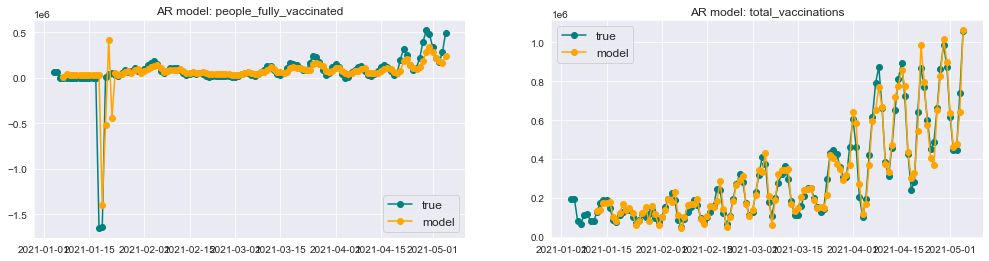

In [21]:

#people
lag_people = optlag_people
ar_people = tsa.AR(time_series_people)
ar_fit_people = ar_people.fit(maxlag=lag_people, ic='aic')
ar_prediction_people = ar_fit_people.predict(start=lag_people)

print('people_fully_vaccinated: ')
print('MAE = {0:.3f}'.format(mean_absolute_error(time_series_people[lag_people:], ar_prediction_people)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series_people[-90:], ar_prediction_people[-90:]))) #error only 

#total
lag_total = optlag_total
ar_total = tsa.AR(time_series_total)
ar_fit_total = ar_total.fit(maxlag=lag_total, ic='aic')
ar_prediction_total = ar_fit_total.predict(start=lag_total)

print(' \n ')
print('total_vaccinations: ')
print('MAE = {0:.3f}'.format(mean_absolute_error(time_series_total[lag_total:], ar_prediction_total)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series_total[-90:], ar_prediction_total[-90:]))) #error only for the last 90 days


#plot people
plt.figure(figsize=(17, 4))
plt.subplot(121)
plt.plot(time_series_people, '-o', label='true', color='teal')
plt.plot(ar_prediction_people, '-o', label='model', color='orange')
plt.legend(fontsize=12);
plt.title('AR model: people_fully_vaccinated')

#for the last 90 days

#plot total vaccinations
plt.subplot(122)
plt.plot(time_series_total, '-o', label='true', color='teal')
plt.plot(ar_prediction_total, '-o', label='model', color='orange')
plt.legend(fontsize=12);
plt.title('AR model: total_vaccinations')



Vemos que el modelo se adapta bien a los datos.

### ARMA model

ARMA stands for **Autoregressive Moving Average**. The difference between ARMA and AR is that the latter models a point in the time series as a linear model of the previous values, and treats the error between the actual data and the predictions as noise. But what if there could still be information in the series of errors? ARMA on the other hand includes the past errors as additional features to the model and is defined as ARMA(p,q).

Just as the name suggests ARMA is comprised of two models, AR(p) (just like above) and MA(q) which is the moving average part and q defines the number of moving average terms.
Let's now run the model with p=2 and q=1 and see the results. You should also play around with these two variables and see the different results that they produce.


*Realizamos un predict de los últimos 15 días*

people_fully_vaccinated: 
MAE = 76779.96
MAE2 = 100724.82


people_fully_vaccinated: 
MAE = 74472.94
MAE2 = 82410.13


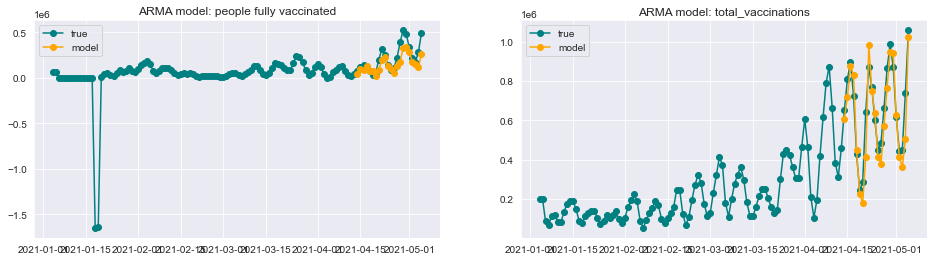

In [22]:
#people
arma_people = tsa.ARMA(time_series_people, order=(2, 1)) #2 p and 1 q for lag and moving average 
arma_fit_people = arma_people.fit()
start=100
arma_prediction_people = arma_fit_people.predict(start=start)

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(time_series_people, '-o', label='true', color='teal')
plt.plot(arma_prediction_people, '-o', label='model', color='orange')
plt.title('ARMA model: people fully vaccinated')
plt.legend();

print('people_fully_vaccinated: ')
print('MAE = {0:.2f}'.format(mean_absolute_error(time_series_people[start:], arma_prediction_people)))
print('MAE2 = {0:.2f}'.format(mean_absolute_error(time_series_people[-15:], arma_prediction_people[-15:]))) #error only for the last 90 days
print('\n')

#total
arma_total = tsa.ARMA(time_series_total, order=(2, 1)) #2 p and 1 q for lag and moving average 
arma_fit_total = arma_total.fit()
arma_prediction_total = arma_fit_total.predict(start=start)

print('people_fully_vaccinated: ')
print('MAE = {0:.2f}'.format(mean_absolute_error(time_series_total[start:], arma_prediction_total)))
print('MAE2 = {0:.2f}'.format(mean_absolute_error(time_series_total[-15:], arma_prediction_total[-15:]))) #error only for the last 90 days


plt.subplot(122)
plt.plot(time_series_total, '-o', label='true', color='teal')
plt.plot(arma_prediction_total, '-o', label='model', color='orange')
plt.title('ARMA model: total_vaccinations')
plt.legend();


### Predicción fuera de la muestra (los próximos 7 días)

Hasta ahora hemos entrenado los modelos con los datos existentes y hemos evaluado su rendimiento comprobando el error medio absoluto de las predicciones frente a los valores reales. Ahora que tenemos dos modelos entrenados, vamos a utilizarlos para predecir los valores futuros (fuera de muestra).

Dado que nuestro modelo **AR** produjo un error menor, primero lo utilizaré para predecir el futuro y luego seguiré los mismos pasos para predecir el precio con los modelos **ARMA** y luego con los **ARIMA**.

Usando el mismo lag óptimo de 13, predecimos 7 valores fuera de muestra. El argumento final de la función predecir, es donde definimos el índice de la última predicción que queremos predecir. Esto para 7 predicciones fuera de muestra será la longitud de la serie + 6.


##### AR

In [23]:
#7 out of sample prediction with AR 
#lag para ambos modelos:
    #-optlag_people
    #-optlag_total

#people
optlag_people = optlag_people
ar_people = tsa.AR(time_series_people)
ar_fit_people = ar_people.fit(maxlag=optlag_people)
ar_forecast_people = ar_fit_people.predict(end=len(time_series_people)+6)[-7:] 
ar_forecast_people

2021-05-06    357574.066851
2021-05-07    157843.831778
2021-05-08    121748.112283
2021-05-09    155125.872790
2021-05-10    143254.539818
2021-05-11    104577.764121
2021-05-12     87448.515605
Freq: D, dtype: float64

In [24]:
#total vaccinations
optlag_total = optlag_total
ar_total = tsa.AR(time_series_total)
ar_fit_total = ar_total.fit(maxlag=optlag_total)
ar_forecast_total = ar_fit_total.predict(end=len(time_series_total)+6)[-7:] 
ar_forecast_total

2021-05-06    1.120213e+06
2021-05-07    9.550641e+05
2021-05-08    6.845424e+05
2021-05-09    5.015089e+05
2021-05-10    5.578869e+05
2021-05-11    8.105653e+05
2021-05-12    1.093153e+06
Freq: D, dtype: float64

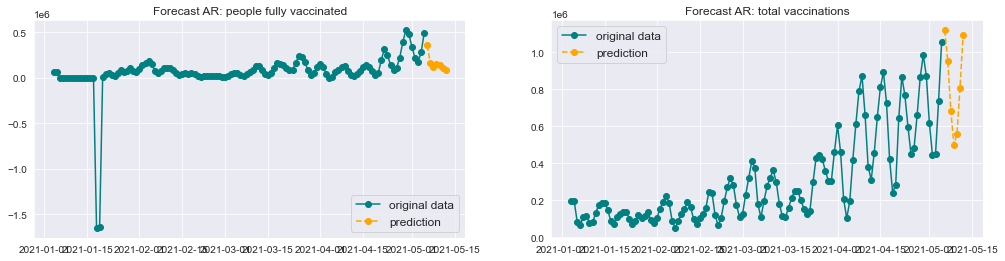

In [35]:
#AR model's 7 out of sample predictions

#people
plt.figure(figsize=(17, 4))
plt.subplot(121)
plt.plot(time_series_people, '-o', label="original data", color='teal')
plt.plot(ar_forecast_people, '--o', label='prediction', color='orange')
plt.title('Forecast AR: people fully vaccinated')
plt.legend(fontsize=12)

#total_vaccinations
plt.subplot(122)
plt.plot(time_series_total, '-o', label="original data", color='teal')
plt.plot(ar_forecast_total, '--o', label='prediction', color='orange')
plt.title('Forecast AR: total vaccinations')
plt.legend(fontsize=12)

##### ARMA

In [30]:
#7 out of sample prediction with ARMA

#people fully vaccinated
arma_people = tsa.ARMA(time_series_people, order=(2, 1)) 
arma_people = arma_people.fit()
arma_forecast_people = arma_people.predict(end=len(time_series_people)+6)[-7:]
arma_forecast_people

2021-05-06    364840.795653
2021-05-07    131435.001641
2021-05-08     95188.540036
2021-05-09     73379.496334
2021-05-10     68162.089668
2021-05-11     65917.178762
2021-05-12     65267.355913
Freq: D, dtype: float64

In [31]:
#total vaccinations
arma_total = tsa.ARMA(time_series_total, order=(2, 1)) 
arma_total = arma_total.fit()
arma_forecast_total = arma_total.predict(end=len(time_series_total)+6)[-7:]
arma_forecast_total

2021-05-06    1.099596e+06
2021-05-07    9.550091e+05
2021-05-08    7.452543e+05
2021-05-09    5.454892e+05
2021-05-10    3.921920e+05
2021-05-11    2.944536e+05
2021-05-12    2.454377e+05
Freq: D, dtype: float64

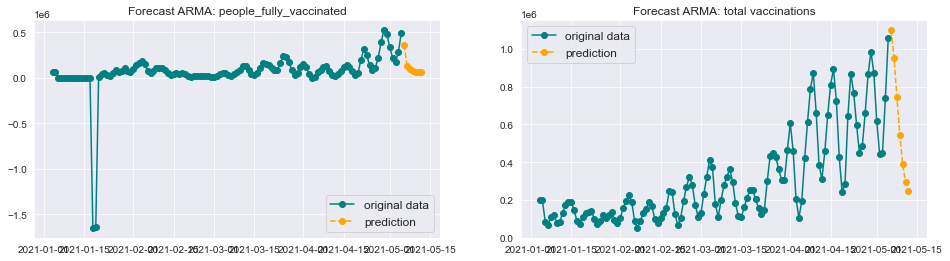

In [34]:
#ARMA model's 7 out sample predicitons 
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(time_series_people, '-o', label="original data", color='teal')
plt.plot(arma_forecast_people, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)
plt.title('Forecast ARMA: people_fully_vaccinated')

plt.subplot(122)
plt.plot(time_series_total, '-o', label="original data", color='teal')
plt.plot(arma_forecast_total, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)
plt.title('Forecast ARMA: total vaccinations')

plt.show()

In [39]:
#and here ARIMA which is basically same thing as ARMA but in a slightly different implementation.
from statsmodels.tsa.arima_model import ARIMA

#ARIMA: people fully vaccinated 
model_people = ARIMA(time_series_people, order=(2,1,1))
arima_fit_people = model_people.fit()
arima_forecast_people= arima_fit_people.forecast(steps=7)[0]
print('ARIMA: total vaccinations')
print(arima_forecast_people)

#ARIMA: totalvaccinations
model_total = ARIMA(time_series_total, order=(2,1,1))
arima_fit_total = model_total.fit()
arima_forecast_total= arima_fit_total.forecast(steps=7)[0]
print('ARIMA, total vaccinations:')
print(arima_forecast_total)

ARIMA: total vaccinations
[399698.78102207 259269.18659091 193733.58551997 197533.1361955
 224754.61266506 244558.82109164 250914.83612066]
ARIMA, total vaccinations:
[1146013.41363615  957746.36392156  661004.13464278  490259.4730757
  566970.66527698  818081.78432112 1046290.99486843]


Lo que hemos predicho no son los precios futuros reales, sino los **valores diferenciados**. Inicialmente hicimos estacionarios los datos diferenciándolos con un retardo de 7, Ahora, para encontrar los precios futuros reales, tenemos que invertir el proceso y cambiar la serie de estacionaria a la forma original. Para ello, añadimos cada valor previsto al valor real de los 7 días anteriores. Los valores de los últimos 7 días en la serie original eran:

In [43]:
print('últimos valores de people_fully_vaccinated: \n',people_fully_vaccinated[-7:]) #the actual last 7 people_fully_vaccinated
print('\n')
print('últimos valores de total_vaccinations: \n', total_vaccinations[-7:])

últimos valores de people_fully_vaccinated: 
 date
2021-04-29    4.689766e+06
2021-04-30    4.894204e+06
2021-05-01    5.026653e+06
2021-05-02    5.113598e+06
2021-05-03    5.202297e+06
2021-05-04    5.394315e+06
2021-05-05    5.696827e+06
Name: people_fully_vaccinated, dtype: float64


últimos valores de total_vaccinations: 
 date
2021-04-29    1.636460e+07
2021-04-30    1.673332e+07
2021-05-01    1.698206e+07
2021-05-02    1.717857e+07
2021-05-03    1.743081e+07
2021-05-04    1.791657e+07
2021-05-05    1.848958e+07
Name: total_vaccinations, dtype: float64


Una vez hecho esto, calculamos los valores reales de las 7 predicciones fuera de la muestra y los representamos con el resto de la serie:

In [48]:
#people
idx_people = ar_forecast_people.index.values
forecast_people_fully_vaccinated = []
lag = 7
for i, diff in enumerate(ar_forecast_people): #choosing AR as it produced lower MAE than ARMA model
    prev_value_people = people_fully_vaccinated[-(lag)+i:][0]
    forecast_people_fully_vaccinated.append(prev_value_people+diff)
    
people_fully_vaccinated_forecast = pd.Series(forecast_people_fully_vaccinated, index=idx_people)
print('Forecast ARIMA: \n')
print(people_fully_vaccinated_forecast)

#total_vaccinations
idx_total = ar_forecast_total.index.values
forecast_total = []

for i, diff in enumerate(ar_forecast_total): #choosing AR as it produced lower MAE than ARMA model
    prev_value_total = total_vaccinations[-(lag)+i:][0]
    forecast_total.append(prev_value_total+diff)
    
total_vaccinations_forecast = pd.Series(forecast_total, index=idx_total)
print('\n')
print('Forecast ARIMA: \n')
print(total_vaccinations_forecast)

Forecast ARIMA: 

2021-05-06    5.047340e+06
2021-05-07    5.052048e+06
2021-05-08    5.148401e+06
2021-05-09    5.268724e+06
2021-05-10    5.345552e+06
2021-05-11    5.498893e+06
2021-05-12    5.784276e+06
dtype: float64


Forecast ARIMA: 

2021-05-06    1.748481e+07
2021-05-07    1.768839e+07
2021-05-08    1.766660e+07
2021-05-09    1.768007e+07
2021-05-10    1.798870e+07
2021-05-11    1.872713e+07
2021-05-12    1.958273e+07
dtype: float64


(array(18683.), array(18772.))

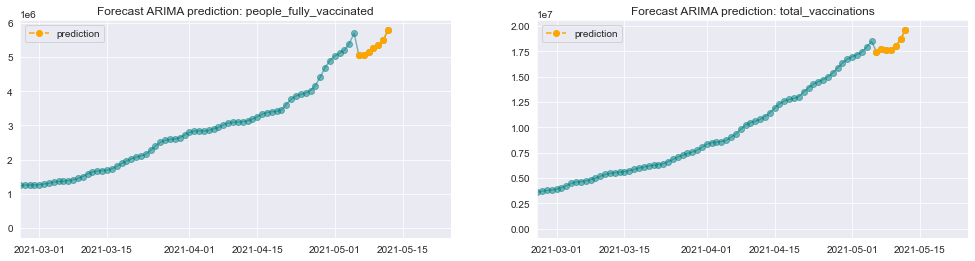

In [59]:
hist_values_people = vacc_Spain['people_fully_vaccinated'].append(people_fully_vaccinated_forecast)
hist_values_total = vacc_Spain['total_vaccinations'].append(total_vaccinations_forecast)

plt.figure(figsize=(17,4))
plt.subplot(121)
plt.plot(hist_values_people, '-o', color='teal', alpha=0.5)
plt.plot(people_fully_vaccinated_forecast, '--o', label='prediction', color='orange')
plt.legend()
plt.title('Forecast ARIMA prediction: people_fully_vaccinated')
plt.xlim('2021-02-25','2021-05-25')

plt.subplot(122)
plt.plot(hist_values_total, '-o', color='teal', alpha=0.5)
plt.plot(total_vaccinations_forecast, '--o', label='prediction', color='orange')
plt.legend()
plt.title('Forecast ARIMA prediction: total_vaccinations')
plt.xlim('2021-02-25','2021-05-25')

In [ ]:
#vacc_Spain.T

# VAR (Vector Autoregressions) Multivariable

In [60]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [61]:
#vacc_Spain.T

In [62]:
#vacc_Spain.T

variables = ['total_vaccinations','people_vaccinated','people_fully_vaccinated','daily_vaccinations']

In [63]:
var_Spain = vacc_Spain[variables]
var_Spain.head(5)

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations
date,,,,
2021-01-04,82834.000000,82834.000000,1.651468e+06,102279.0
2021-01-05,139339.000000,139339.000000,1.651468e+06,56505.0
2021-01-06,167094.453549,167094.366452,1.651468e+06,45248.0
2021-01-07,207323.000000,207323.000000,1.651468e+06,41496.0
2021-01-08,277976.000000,277976.000000,1.651468e+06,48786.0


##No queda claro el gráfico porque se ve mal.

**Importante incluir una medida de prestación para el VAR** 
https://www.statsmodels.org/dev/vector_ar.html#post-estimation-analysis

# 2. VAR

La autorregresión vectorial (VAR) es un algoritmo de previsión multivariante que se utiliza cuando dos o más series temporales se influyen mutuamente.

Es decir, los requisitos básicos para utilizar el VAR son:
- Se necesitan al menos dos series temporales (variables)
- Las series temporales deben influirse mutuamente.

Bien, ¿en qué se diferencia el VAR de otros modelos autorregresivos como AR, ARMA o ARIMA?

La principal diferencia es que esos modelos son unidireccionales, es decir, los predictores influyen en Y y no a la inversa. En cambio, la autorregresión vectorial (VAR) es bidireccional. Es decir, las variables se influyen mutuamente. 

En el modelo VAR, cada variable se modela como una combinación lineal de los valores pasados de sí misma y de los valores pasados de otras variables del sistema. Dado que tiene múltiples series temporales que se influyen mutuamente, se modela como un sistema de ecuaciones con una ecuación por variable (serie temporal).

Es decir, si tiene 5 series temporales que se influyen mutuamente, tendremos un sistema de 5 ecuaciones.

The procedure to build a VAR model involves the following steps:

    1. Analyze the time series characteristics
    2. Test for causation amongst the time series
    3. Test for stationarity
    4. Transform the series to make it stationary, if needed
    5. Find optimal order (p)
    6. Prepare training and test datasets
    7. Train the model
    8. Roll back the transformations, if any.
    9. Evaluate the model using test set
    10. Forecast to future


In [74]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

Vamos a utilizar el var_Spain que hemos utilizado antes con cuatro variables. 

In [87]:
var_Spain.head(5)

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations
date,,,,
2021-01-04,82834.000000,82834.000000,1.651468e+06,102279.0
2021-01-05,139339.000000,139339.000000,1.651468e+06,56505.0
2021-01-06,167094.453549,167094.366452,1.651468e+06,45248.0
2021-01-07,207323.000000,207323.000000,1.651468e+06,41496.0
2021-01-08,277976.000000,277976.000000,1.651468e+06,48786.0


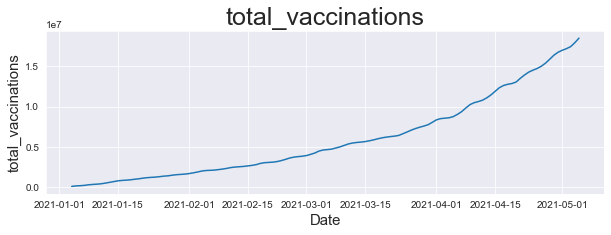

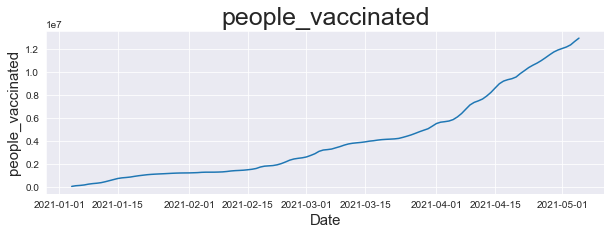

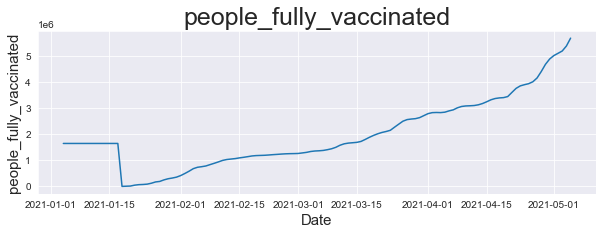

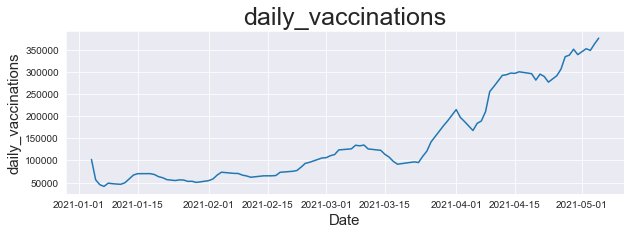

In [78]:
#visualización de las variables

for i in var_Spain.columns.to_list():

    sns.set_style("darkgrid")
    plt.figure(figsize=(10, 3))
    sns.lineplot(data=vacc_Spain[i])
    #sns.lineplot(data = vacc_Spain['daily_vaccinations'])
    plt.title(i,fontsize=25)
    plt.xlabel('Date',fontsize=15)
    plt.ylabel(i, fontsize=15)
    plt.show()

### Comprobación de la causalidad mediante la prueba de causalidad de Granger

La base de la autoregresión vectorial es que cada una de las series temporales del sistema se influye mutuamente. Es decir, se puede predecir la serie con valores pasados de ella misma junto con otras series del sistema.

Utilizando la **prueba de causalidad de Granger**, es posible comprobar esta relación incluso antes de construir el modelo.

Entonces, ¿qué prueba realmente la causalidad de Granger?

La causalidad de Granger comprueba la hipótesis nula de que los **coeficientes de los valores pasados en la ecuación de regresión son cero**.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

In [82]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [83]:
grangers_causation_matrix(var_Spain, variables = var_Spain.columns) 

,total_vaccinations_x,people_vaccinated_x,people_fully_vaccinated_x,daily_vaccinations_x
total_vaccinations_y,1.0,0.0002,0.2094,0.0000
people_vaccinated_y,0.0,1.0000,0.0446,0.0000
people_fully_vaccinated_y,0.0,0.0000,1.0000,0.0397
daily_vaccinations_y,0.0,0.0000,0.0160,1.0000


Entonces, ¿cómo interpretar los p-values?

Si un valor p-value dado es < nivel de significación (0,05), entonces, la  serie X correspondiente (columna) provoca la serie Y (fila).

Por ejemplo, el p-value = 0.0160 indica que **'people_fully_vaccinated_x'** causa **'daily_vaccinations_y'**

### Cointegration test

La prueba de cointegración ayuda a establecer la presencia de una conexión estadísticamente significativa entre dos o más series temporales.

Para entenderlo, primero hay que saber qué es el "orden de integración" (d). El orden de integración (d) no es más que el número de diferenciaciones necesarias para hacer estacionaria una serie temporal no estacionaria. https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

Ahora bien, cuando se tienen dos o más series temporales, y existe una combinación lineal de ellas que tiene un orden de integración (d) menor que el de las series individuales, entonces **se dice que el conjunto de series está cointegrado.**

Cuando dos o más series temporales están cointegradas, significa que tienen una relación a largo plazo y estadísticamente significativa.

In [84]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)



In [85]:
cointegration_test(var_Spain)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
total_vaccinations ::  186.35    > 40.1749   =>   True
people_vaccinated ::  40.09     > 24.2761   =>   True
people_fully_vaccinated ::  20.62     > 12.3212   =>   True
daily_vaccinations ::  7.77      > 4.1296    =>   True


El modelo VAR se ajustará a df_train y luego se utilizará para pronosticar las 10 observaciones siguientes

In [86]:
# Splitting the dataset into training and test data.
nobs = 10
df_train, df_test = var_Spain[0:-nobs], var_Spain[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(112, 4)
(10, 4)


**Comprobar la estacionariedad y hacer que la serie temporal sea estacionaria**

Una serie temporal estacionaria es aquella cuyas características, como la media y la varianza, no cambian con el tiempo.

>En el caso de que una serie no es estacionaria, se la hace estacionaria diferenciando la serie una vez y repitiendo la prueba de nuevo hasta que se convierta en estacionaria.

Dado que la diferenciación reduce la longitud de la serie en 1 y que todas las series temporales deben tener la misma longitud, es necesario diferenciar todas las series del sistema si se decide diferenciarlas.

Una prueba que podemos hacer para comprobar que una serie temporal es estacionaria es el test de **Prueba de Dickey Fuller aumentada**.

In [88]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   
        
#referencia: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [89]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "total_vaccinations" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 3.1827
 No. Lags Chosen       = 9
 Critical value 1%     = -3.496
 Critical value 5%     = -2.89
 Critical value 10%    = -2.582
 => P-Value = 1.0. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "people_vaccinated" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 2.5666
 No. Lags Chosen       = 9
 Critical value 1%     = -3.496
 Critical value 5%     = -2.89
 Critical value 10%    = -2.582
 => P-Value = 0.9991. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "people_fully_vaccinated" 
    -------------------------------------------

Las series de nuestras variables no son estacionarias. Vamos a asegurarnos de que sí diferenciándolas.

In [90]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [91]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "total_vaccinations" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.5409
 No. Lags Chosen       = 11
 Critical value 1%     = -3.498
 Critical value 5%     = -2.891
 Critical value 10%    = -2.583
 => P-Value = 0.9861. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "people_vaccinated" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.9919
 No. Lags Chosen       = 8
 Critical value 1%     = -3.496
 Critical value 5%     = -2.89
 Critical value 10%    = -2.582
 => P-Value = 0.7562. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "people_fully_vaccinated" 
    -------------------------------------

Hemos conseguido que "people_fully_vaccinated" sea estacionaria, pero el resto siguen siendo no estacionarias. Diferenciamos otra vez:

In [92]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [93]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "total_vaccinations" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5505
 No. Lags Chosen       = 10
 Critical value 1%     = -3.498
 Critical value 5%     = -2.891
 Critical value 10%    = -2.583
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "people_vaccinated" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.4497
 No. Lags Chosen       = 7
 Critical value 1%     = -3.496
 Critical value 5%     = -2.89
 Critical value 10%    = -2.582
 => P-Value = 0.0094. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "people_fully_vaccinated" 
    -----------------------------------------------
 Null Hypothesis: Data has unit 

Ahora todas las series temporales son estacionarias.

### Seleccionar el orden (P) del modelo VAR

In [96]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)

In [97]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,84.09,84.20,3.311e+36,84.13
1,83.67,84.19*,2.168e+36,83.88
2,83.32,84.27,1.531e+36,83.70
3,83.12,84.49,1.261e+36,83.67
4,82.96,84.76,1.089e+36,83.69
5,82.81,85.02,9.411e+35,83.70
6,82.66,85.30,8.296e+35,83.73
7,82.04,85.10,4.598e+35,83.28
8,81.98,85.46,4.458e+35,83.38
9,81.66,85.57,3.419e+35,83.24


No son resultados muy buenos porque los números son muy altos.

Tomaremos el *p=lag=12* que es el menor AIC.

In [98]:
p = 12 #el lag de antes

#implementamos el modelo
model_fitted = model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 13, May, 2021
Time:                     20:05:05
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    85.5243
Nobs:                     98.0000    HQIC:                   82.4455
Log likelihood:          -4297.59    FPE:                1.17151e+35
AIC:                      80.3543    Det(Omega_mle):     2.31409e+34
--------------------------------------------------------------------
Results for equation total_vaccinations
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                            9548.263980      5184.669132            1.842           0.066
L1.total_vaccinations              -0.879390         0.435602           -2.019        

### Comprobación de la correlación de la serie de los residuos (errores) mediante el estadístico de Durbin Watson

La correlación serial de los residuos se utiliza para comprobar si hay algún patrón sobrante en los residuos (errores). Si queda alguna correlación en los residuos, entonces, hay algún patrón en la serie temporal que todavía queda por explicar por el modelo. En ese caso, el curso de acción típico es aumentar el orden del modelo o inducir más predictores en el sistema o buscar un algoritmo diferente para modelar la serie temporal.

Así pues, la comprobación de la correlación serial sirve para garantizar que el modelo es suficientemente capaz de explicar las varianzas y los patrones de las series temporales.

In [102]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(var_Spain.columns, out):
    def adjust(val, length= 4): return str(val).ljust(length)
    print(adjust(col), ':', round(val, 2))

total_vaccinations : 1.83
people_vaccinated : 1.84
people_fully_vaccinated : 1.29
daily_vaccinations : 1.8


### Procedemos a realizar el pronóstico

In [104]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
#forecast_input

12


In [107]:
# Forecast de los 10 días siguientes
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=var_Spain.index[-nobs:], columns=var_Spain.columns + '_2d')
df_forecast

,total_vaccinations_2d,people_vaccinated_2d,people_fully_vaccinated_2d,daily_vaccinations_2d
date,,,,
2021-04-26,27571.451863,-12294.310876,291780.129860,3423.272691
2021-04-27,68269.290720,31978.971814,173211.536224,10252.664661
2021-04-28,78229.893999,60047.047344,-309131.812783,-29279.797173
2021-04-29,10443.799001,15020.649180,-454690.908914,12450.153722
2021-04-30,-118285.322647,-78098.449374,107695.812861,-11894.896419
2021-05-01,-40661.065329,-41491.907609,301709.972228,6382.181181
2021-05-02,-33166.986596,-18489.339804,176375.844726,355.147078
2021-05-03,28181.496809,41272.068885,-123676.508134,-3897.295432
2021-05-04,41652.572830,32827.669394,-64369.139402,6217.494323


Estos son los pronósticos, pero están en la escala de los datos de entrenamiento utilizados por el modelo. Así que, para devolverlo a su escala original, hay que **desdiferenciarlo** tantas veces como se hayan diferenciado los datos de entrada originales. En este caso los dediferenciamos 2 veces. 

In [108]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [110]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        

In [111]:
var_Spain.columns

Index(['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
       'daily_vaccinations'],
      dtype='object')

In [114]:
df_results.loc[:, ['total_vaccinations_forecast', 'people_vaccinated_forecast', 'people_fully_vaccinated_forecast', 'daily_vaccinations_forecast']]
             

,total_vaccinations_forecast,people_vaccinated_forecast,people_fully_vaccinated_forecast,daily_vaccinations_forecast
date,,,,
2021-04-26,1.495042e+07,1.096758e+07,4.277686e+06,301591.272691
2021-04-27,1.525319e+07,1.117067e+07,4.781118e+06,322490.210044
2021-04-28,1.563418e+07,1.143380e+07,4.975418e+06,314109.350224
2021-04-29,1.602561e+07,1.171196e+07,4.715028e+06,318178.644126
2021-04-30,1.629876e+07,1.191202e+07,4.562333e+06,310353.041610
2021-05-01,1.653125e+07,1.207058e+07,4.711349e+06,308909.620275
2021-05-02,1.673057e+07,1.221066e+07,5.036740e+06,307821.346018
2021-05-03,1.695808e+07,1.239201e+07,5.238454e+06,302835.776329
2021-05-04,1.722723e+07,1.260619e+07,5.375800e+06,304067.700963


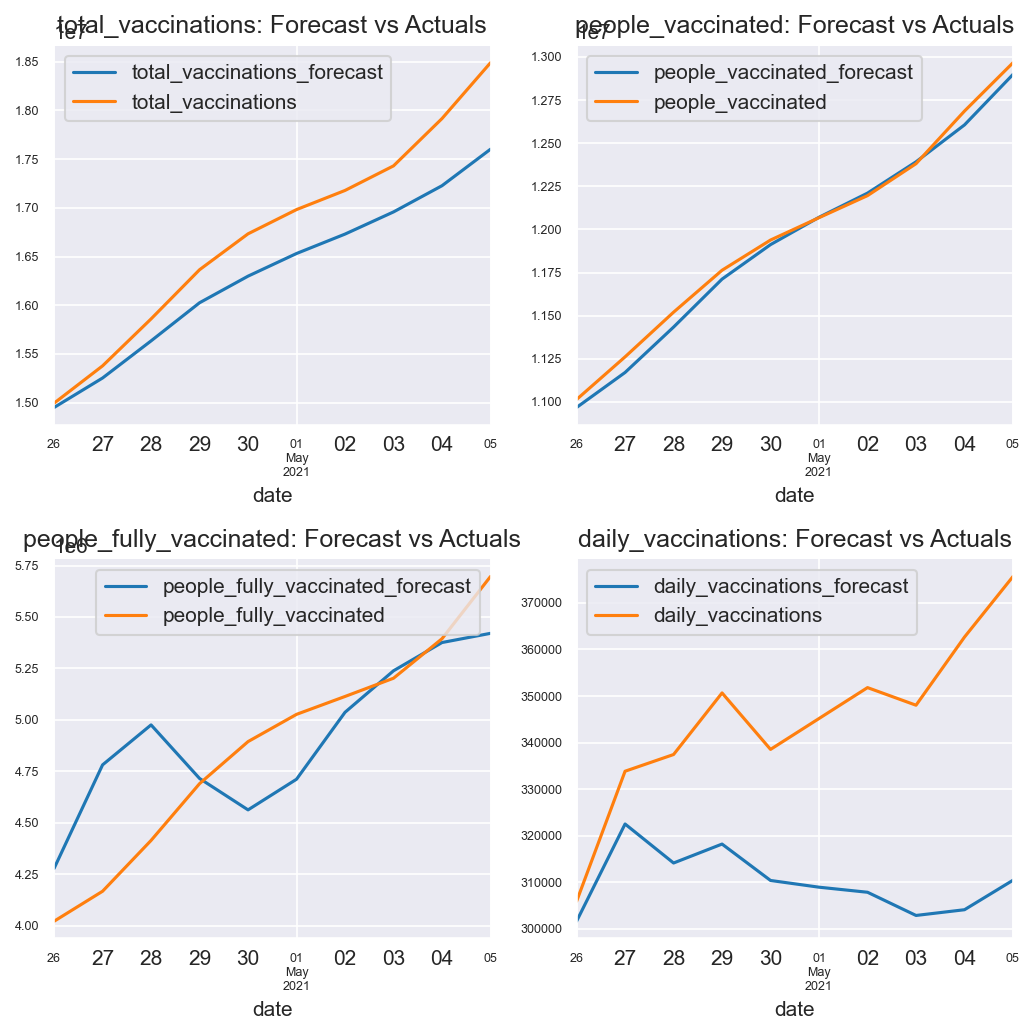

In [118]:
fig, axes = plt.subplots(nrows=int(len(var_Spain.columns)/2), ncols=2, dpi=150, figsize=(7,7))
for i, (col,ax) in enumerate(zip(var_Spain.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Para evaluar las previsiones, vamos a calcular un conjunto completo de métricas, a saber, el **MAPE, ME, MAE, MPE, RMSE, corr y minmax**.

In [119]:
df_results.columns

Index(['total_vaccinations_2d', 'people_vaccinated_2d',
       'people_fully_vaccinated_2d', 'daily_vaccinations_2d',
       'total_vaccinations_1d', 'total_vaccinations_forecast',
       'people_vaccinated_1d', 'people_vaccinated_forecast',
       'people_fully_vaccinated_1d', 'people_fully_vaccinated_forecast',
       'daily_vaccinations_1d', 'daily_vaccinations_forecast'],
      dtype='object')

In [121]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

#Vemos las prestaciones
print('Forecast Accuracy of: total_vaccinations')
accuracy_prod = forecast_accuracy(df_results['total_vaccinations_forecast'].values, df_test['total_vaccinations'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: people_vaccinated')
accuracy_prod = forecast_accuracy(df_results['people_vaccinated_forecast'].values, df_test['people_vaccinated'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: people_fully_vaccinated')
accuracy_prod = forecast_accuracy(df_results['people_fully_vaccinated_forecast'].values, df_test['people_fully_vaccinated'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: daily_vaccinations')
accuracy_prod = forecast_accuracy(df_results['daily_vaccinations_forecast'].values, df_test['daily_vaccinations'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: total_vaccinations
mape :  0.0238
me   :  -411667.4796
mae  :  411667.4796
mpe  :  -0.0238
rmse :  475691.8041
corr :  0.9984
minmax :  0.0238

Forecast Accuracy of: people_vaccinated
mape :  0.004
me   :  -42109.5122
mae  :  47671.4592
mpe  :  -0.0036
rmse :  56984.1865
corr :  0.998
minmax :  0.004

Forecast Accuracy of: people_fully_vaccinated
mape :  0.0548
me   :  47528.8254
mae  :  251302.0647
mpe  :  0.0153
rmse :  324482.5478
corr :  0.7843
minmax :  0.0511

Forecast Accuracy of: daily_vaccinations
mape :  0.0988
me   :  -34889.5618
mae  :  34889.5618
mpe  :  -0.0988
rmse :  39403.1387
corr :  0.0657
minmax :  0.0988


### Pronóstico real: 10 días

In [122]:
var_Spain

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations
date,,,,
2021-01-04,8.283400e+04,8.283400e+04,1.651468e+06,102279.0
2021-01-05,1.393390e+05,1.393390e+05,1.651468e+06,56505.0
2021-01-06,1.670945e+05,1.670944e+05,1.651468e+06,45248.0
2021-01-07,2.073230e+05,2.073230e+05,1.651468e+06,41496.0
2021-01-08,2.779760e+05,2.779760e+05,1.651468e+06,48786.0
...,...,...,...,...
2021-05-01,1.698206e+07,1.206815e+07,5.026653e+06,345164.0
2021-05-02,1.717857e+07,1.219608e+07,5.113598e+06,351805.0
2021-05-03,1.743081e+07,1.238121e+07,5.202297e+06,348020.0


In [127]:
# First Differencing
var_Spain_differenced = var_Spain.diff().dropna()
#second differencing
var_Spain_differenced = var_Spain_differenced.diff().dropna()

# ADF Test on each column of 1st Differences Dataframe
for name, column in var_Spain_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "total_vaccinations" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.6668
 No. Lags Chosen       = 8
 Critical value 1%     = -3.491
 Critical value 5%     = -2.888
 Critical value 10%    = -2.581
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "people_vaccinated" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5279
 No. Lags Chosen       = 8
 Critical value 1%     = -3.491
 Critical value 5%     = -2.888
 Critical value 10%    = -2.581
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "people_fully_vaccinated" 
    -----------------------------------------------
 Null Hypothesis: Data has unit 

In [128]:
idx_20 = ar_forecast_people.index.values

forecast_input = var_Spain.values

fc = model_fitted.forecast(y=forecast_input, steps=7)
df_forecast = pd.DataFrame(fc, index=idx_20, columns=var_Spain.columns + '_2d')
df_forecast

,total_vaccinations_2d,people_vaccinated_2d,people_fully_vaccinated_2d,daily_vaccinations_2d
2021-05-06,-5.702174e+07,-4.805157e+07,6.857792e+07,-1.180136e+07
2021-05-07,-5.618865e+07,-5.035394e+07,3.467836e+07,-7.191648e+06
2021-05-08,-2.982765e+07,-3.415915e+07,-2.333070e+07,-5.090975e+06
2021-05-09,5.242586e+06,-8.259242e+06,4.618119e+07,-3.904032e+06
2021-05-10,1.249189e+07,1.780231e+05,7.121006e+07,-8.136810e+05
2021-05-11,7.440658e+06,1.610886e+06,2.576994e+07,-6.278995e+05
2021-05-12,5.681739e+06,1.224631e+06,-2.895025e+06,-1.655111e+06


In [129]:
df_results = invert_transformation(var_Spain, df_forecast, second_diff=True)        

In [130]:
df_results.loc[:, ['total_vaccinations_forecast', 'people_vaccinated_forecast', 'people_fully_vaccinated_forecast', 'daily_vaccinations_forecast']]


,total_vaccinations_forecast,people_vaccinated_forecast,people_fully_vaccinated_forecast,daily_vaccinations_forecast
2021-05-06,-3.795914e+07,-3.480480e+07,7.457726e+07,-1.141265e+07
2021-05-07,-1.505965e+08,-1.329301e+08,1.781360e+08,-3.039264e+07
2021-05-08,-2.930615e+08,-2.652145e+08,2.583641e+08,-5.446361e+07
2021-05-09,-4.302840e+08,-4.057582e+08,3.847734e+08,-8.243861e+07
2021-05-10,-5.550145e+08,-5.461239e+08,5.823927e+08,-1.112273e+08
2021-05-11,-6.723044e+08,-6.848786e+08,8.057820e+08,-1.406439e+08
2021-05-12,-7.839126e+08,-8.224088e+08,1.026276e+09,-1.717155e+08


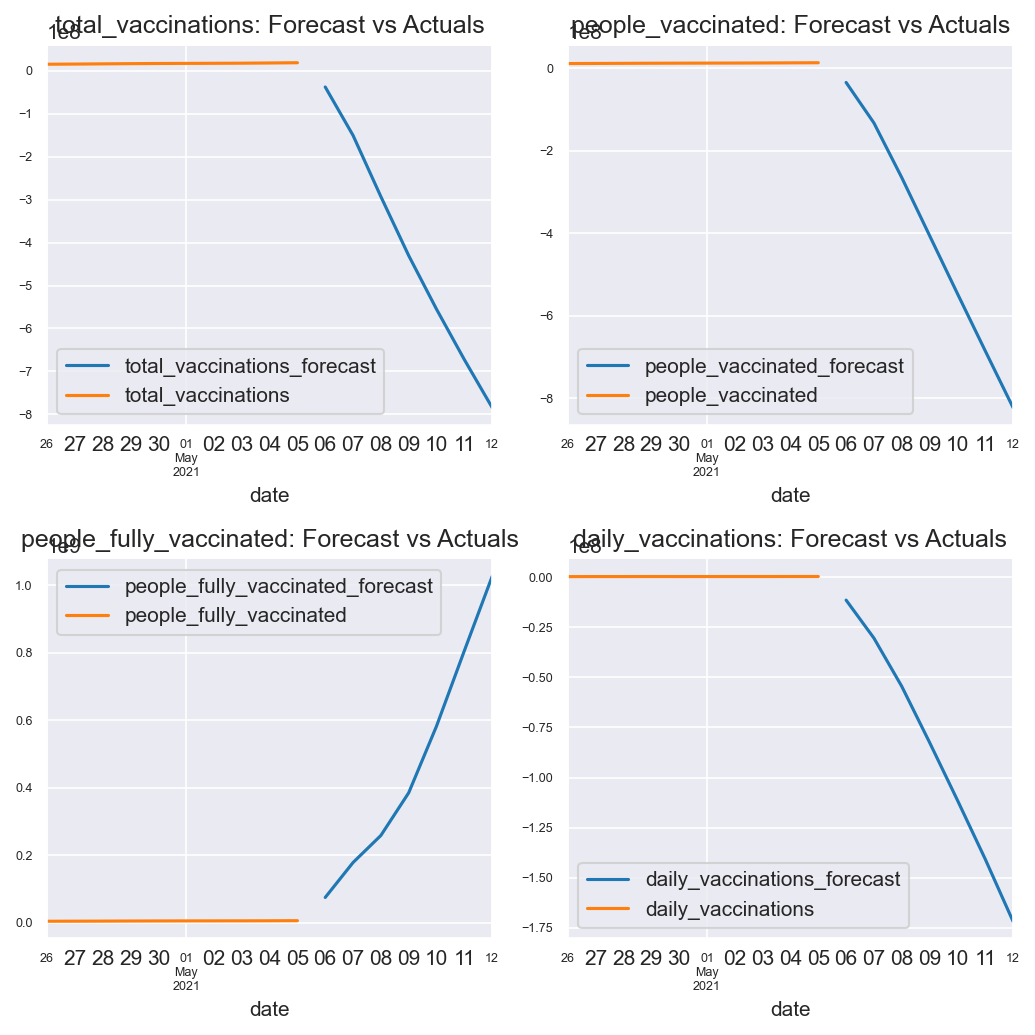

In [131]:
fig, axes = plt.subplots(nrows=int(len(var_Spain.columns)/2), ncols=2, dpi=150, figsize=(7,7))
for i, (col,ax) in enumerate(zip(var_Spain.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# 3. Ajustes de curva de vacunación: lineal, potencia, cuadrática, exponencial y logística


## Europa

In [174]:
df = pd.read_csv('covid_vaccine_data.csv', index_col=0)
df.date = pd.to_datetime(df.date)
df.iso_code = df.iso_code.astype('category')
df.drop(columns=['source_name', 'source_website'], inplace=True)

In [175]:
Europe = ['ALB', 'AND', 'AUT', 'BLR', 'BEL', 'BIH', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FRO', 'FIN', 'FRA', 'DEU', 'GIB', 'GRC', 'HUN', 'ISL', 'IRL', 'IMN', 'ITA', 'XKX', 'LVA', 'LIE', 'LTU', 'LUX', 'MKD', 'MLT', 'MDA', 'MCO', 'MNE', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SMR', 'SRB', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'UKR', 'GBR', 'VAT', 'RSB']

In [176]:
import seaborn as sns

In [177]:
df['in_europe'] = df.iso_code.isin(Europe)

Ucrania y UK no están incluidos porque no siguen la misma tendencia que el resto de europa:

In [178]:
sdf = df[df.in_europe]
sdf = sdf[sdf.Population > 7e6]
sdf = sdf[sdf.iso_code != 'UKR'] # Ukraine is noisy

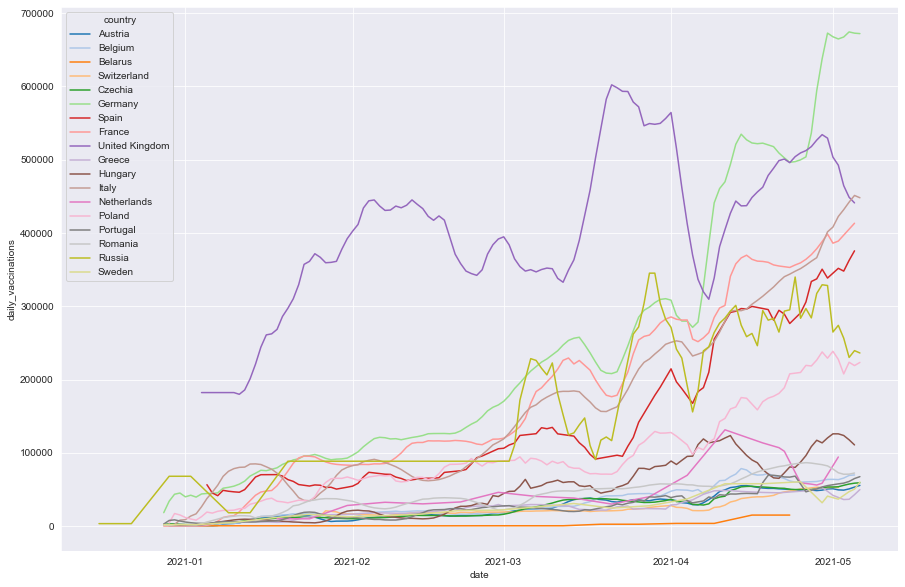

In [179]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=sdf, 
    x='date',
    y='daily_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    markers=True,
    ax=ax,
)

[None]

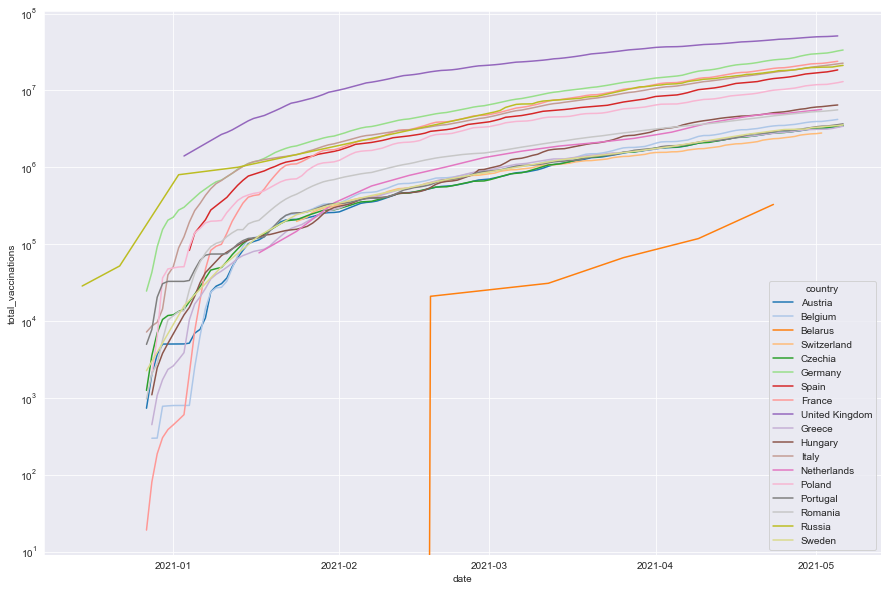

In [180]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=sdf, 
    x='date',
    y='total_vaccinations',
    hue='country',
#     legend=False,
    palette='tab20',
    ax=ax,
)
ax.set(yscale='log')

Observamos que hay una clara tendencia exponencial:

[None]

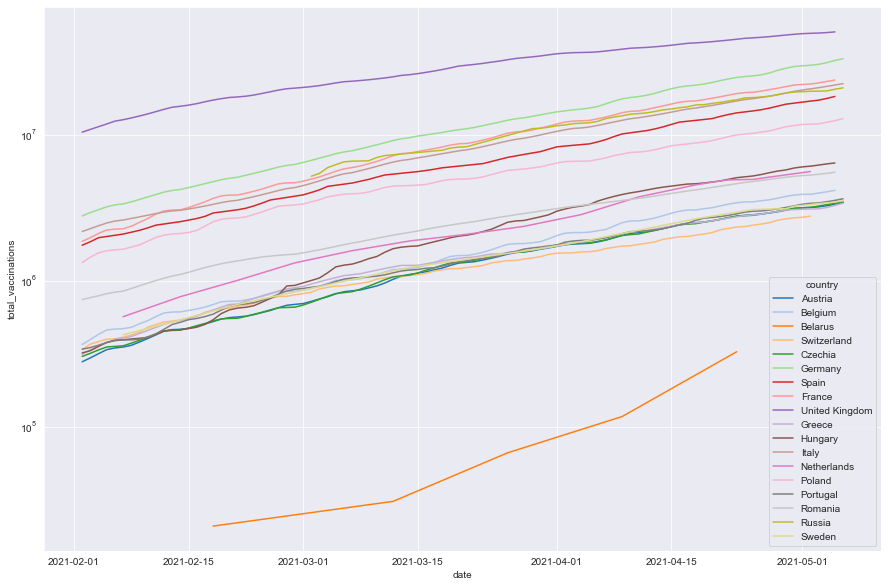

In [181]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=sdf[sdf.date > '2021-02'], 
    x='date',
    y='total_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    ax=ax,
)
ax.set(yscale='log')

In [182]:
import inspect

In [183]:
def _augment_df(df, fn, name=None, register=None):
    name = fn.__name__ if name is None else name
    params = list(inspect.signature(fn).parameters.keys())
#     fixed = {p: df.attrs["uniq"][p] for p in params if p not in df.columns}
#     params = [p for p in params if p not in fixed
#     if len(fixed) > 0:
#         fn = functools.partial(fn, **fixed)

def augment_df(df, *fns, register=None):
    for f in fns:
        _augment_df(df, f, register=register)

In [184]:
def normalized_vaccinations(iso_code, total_vaccinations, Population):
    return (total_vaccinations - starting_vaccinations.loc[iso_code]) / Population
    
#augment_df(sdf, normalized_vaccinations)

In [185]:
from scipy.optimize import curve_fit

def lineal(x, a, b):
    return a*x +b 

def powerlaw(x, a, b, c):
    return c*x**a + b

def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

def exp(x, a, b, c):
    return a**(x-c)+b

def logistic(x, a, b, c, d):
    return a/(1+np.exp(b*(x-c))) + d

funcs = [powerlaw, quadratic, exp, logistic, lineal]

In [190]:
starting_vaccinations = sdf[sdf.date == '2021-02-01'][['iso_code', 'total_vaccinations']].set_index('iso_code')

In [191]:
#normalizamos por población
augment_df(sdf, normalized_vaccinations)

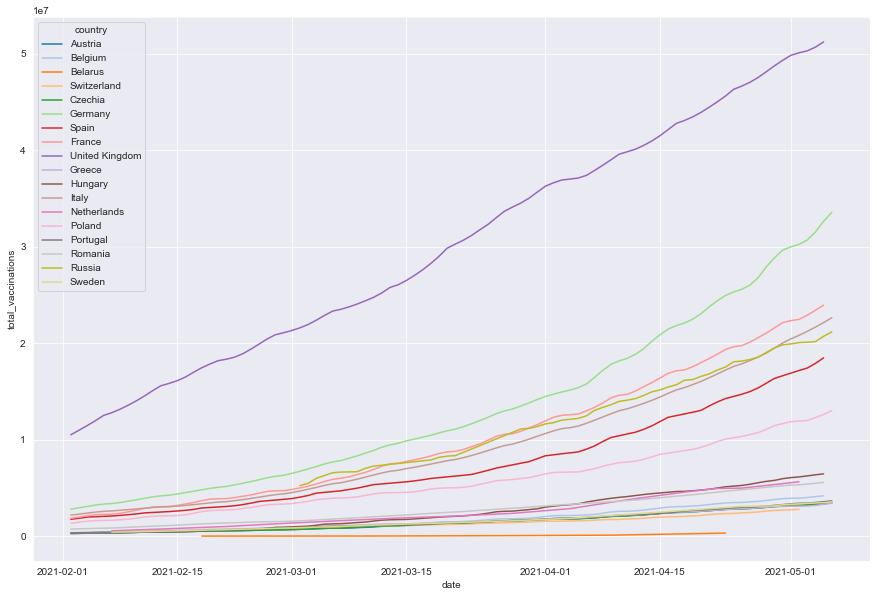

In [193]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=sdf[sdf.date > '2021-02'], 
    x='date',
    y='total_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    ax=ax,
)
# ax.set(yscale='log')

Reino Unido va por libre

In [198]:
ssdf = sdf[~sdf.iso_code.isin(['GBR', 'HUN'])]
ssdf = ssdf[ssdf.date > '2021-02']

In [199]:
from datetime import datetime as dt


data = ssdf.copy()
data = data[~data.normalized_vaccinations.isna()]
data = data[data.date > '2021-02']

#x = data.date.map(dt.datetime.toordinal).to_numpy()
x = data.date.map(dt.toordinal).to_numpy()
y = data.normalized_vaccinations.to_numpy()
max_, min_ = np.max(x), np.min(x)
x = (x-min_)/(max_-min_)

AttributeError: 'DataFrame' object has no attribute 'normalized_vaccinations'

In [195]:
optimal_params = {f:curve_fit(f, x, y) for f in funcs}

NameError: name 'y' is not defined

In [196]:
dates = pd.date_range(start='2021-02-01', end='2021-06-01')
#xt = dates.map(dt.datetime.toordinal).to_numpy()
xt = dates.map(dt.toordinal).to_numpy()
xt = (xt-min_)/(max_-min_)

ssdf = sdf[~sdf.iso_code.isin(['GBR', 'HUN'])]

NameError: name 'min_' is not defined

In [194]:
dates = pd.date_range(start='2021-02-01', end='2021-08-01')
#xt = dates.map(dt.datetime.toordinal).to_numpy()
xt = dates.map(dt.toordinal).to_numpy()
xt = (xt-min_)/(max_-min_)

ssdf = sdf[~sdf.iso_code.isin(['GBR', 'HUN'])]


fig, axes = plt.subplots(1, 2, figsize=(25,10))
for i, ax in enumerate(axes):
    g = sns.lineplot(
        data=ssdf[ssdf.date > '2021-02'], 
        x='date',
        y='normalized_vaccinations',
        hue='country',
        palette='tab20',
    #     legend=False,
        alpha=0.5,
        ax=ax,
    )

    if i == 0:
        ax.set(yscale='log')
    for i, f in enumerate(funcs):
        popt, _ = optimal_params[f]
        yt = f(xt, *popt)
        ax.plot(dates, yt, ls=':', label=f.__name__, color=monokai_cmap[i], zorder=100)

    ax.axhline(1, color='black', ls='--', alpha=0.7, label='poblacion')
    ax.axhline(0.7, color='lightgray', ls='-.', alpha=0.7, label='rebaño')
    ax.legend()

NameError: name 'min_' is not defined